# Tuning Book for NREL 5MW Turbine

### Introduction notes

In [46]:
# This book presents an example of tuning a FLORIS model to SOWFA data of a turbine operating in various conditions
# For information about the provided data sets see the also provided noteboooks:
#   reviewPowerData.ipynb
#   showWakeProfilesFromSOWFA.ipynb

In [47]:
# Basic module imports
%matplotlib inline
import os
import time
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import cPickle as pickle
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [48]:
# Imports from openmdao
from openmdao.api import Problem, Group, IndepVarComp
from pyoptsparse import Optimization, OPT, SNOPT


In [49]:
# Imports from FLORIS
from florisse.floris import DirectionGroup
from florisse import config

ImportError: cannot import name DirectionGroup

In [50]:
# Load the SOWFA data sets
yawPos,avPowersYaw, yawPosI2,avPowersYawI2 = pickle.load( open( os.path.join('data','yawPower.p'), "rb" ) )
spacing,avPowersSpace = pickle.load( open( os.path.join('data','spacePower.p'), "rb" ) )
offset4D,avPowersOffset4D = pickle.load( open( os.path.join('data','offset4DPower.p'), "rb" ) )
offset6D,avPowersOffset6D = pickle.load( open( os.path.join('data','offset6DPower.p'), "rb" ) )

### Initial FLORIS Settings

In [51]:
# These initial settings are taken from 
# Gebraad, P. M. O., Teeuwisse, F. W., van Wingerden, J. W., Fleming, P. a., Ruben, S. D., Marden, J. R., & Pao, L. Y. (2014). Wind plant power optimization through yaw control using a parametric model 
#    for wake effects-a CFD simulation study. Wind Energy, n/a–n/a. http://doi.org/10.1002/we.1822
# Which were arrived at through manual tuning and adjustment to SOWFA data selected from
# Fleming, P. A., Gebraad, P. M. O., Lee, S., van Wingerden, J.-W., Johnson, K. E., Churchfield, M., … Moriarty, P. J. (2014). Simulation comparison of wake mitigation control strategies for a two-turbine case. 
#    Wind Energy, n/a–n/a. http://doi.org/10.1002/we.1810

In [52]:
# These first set of parameters set certain behaviors of the FLORIS model
# Note that we would like to make smooth + rotor THE FLORIS model very soon

model = 'smooth'    # options: 'original', 'smooth'. 'original' uses a Fortran implementation of the original C 
                    # code used in Gebraad et al. Wind Energy 2014. 'smooth' refers to the the model changes presented in Thomas
                    # et al. Wind Engineering 2016 (in review), but does not necessarily use the cosine factor.
flat = False        # if False, will use cosine smoothing factor. This is only available if model = 'smooth'
rotor = True        # if True, will use an improved rotor model as presented in Gebraad et al. Wind Energy 2016

if model == 'smooth':
    differentiable = True
else:
    differentiable = False


### NREL 5MW direct settings

In [53]:
# Certain components of the model are fixed properties of the turbine used which can be derived/computed
# directly from FAST

In [54]:
# Set properties of the turbine
rotorDiameter = 126.0
generatorEfficiency = 0.944

In [55]:
# The Ct/Cp table is an important component of the turbine model
# NOTE ANOTHER SHEET GIVES AN EXAMPLE ON HOW THIS CAN BE DERIVED FROM FAST
# VERY IMPORTANT TO NOTE: CP/CT should include ALL efficency losses EXCEPT generator efficiency

# Load the Cp table for NREL 5MW
NREL5MWCPCT = pickle.load(open('../NREL5MWCPCT_smooth_dict.p'))
datasize = NREL5MWCPCT['CP'].size
# These are arrays of CP and CT versus wind speed
NREL5MWCPCT

{'CP': array([ 0.        ,  0.15643578,  0.31287155,  0.41306749,  0.44895632,
         0.46155227,  0.46330747,  0.46316077,  0.46316077,  0.46280642,
         0.45223111,  0.39353012,  0.3424487 ,  0.2979978 ,  0.25931677,
         0.22565665,  0.19636572,  0.17087684,  0.1486965 ,  0.12939524,
         0.11259934,  0.0979836 ,  0.08526502,  0.07419736,  0.06456631,
         0.05618541,  0.04889237,  0.        ]),
 'CT': array([ 1.10610965,  1.09515807,  1.0227122 ,  0.9196487 ,  0.8519047 ,
         0.80328229,  0.76675469,  0.76209299,  0.76209299,  0.75083241,
         0.67210674,  0.52188504,  0.43178758,  0.36443258,  0.31049874,
         0.26696686,  0.22986909,  0.19961578,  0.17286245,  0.15081457,
         0.13146666,  0.11475968,  0.10129584,  0.0880188 ,  0.07746819,
         0.06878621,  0.05977061,  0.        ]),
 'wind_speed': array([  0.        ,   2.5       ,   3.52338654,   4.57015961,
          5.61693268,   6.66370575,   7.71047882,   8.75725189,
          9.804024

### Other model parameters

In [56]:
# Describe this more later

In [57]:
## Set models for FLORIS parameters
# These are the simulation parameters specific to a given turbine / enviornment

# power
pP = 1.88   # control Cp adjustment to yaw

# deflection
kd = 0.15                       # adjust yaw deflection
# global initialWakeDisplacement
initialWakeDisplacement = -4.5  # initial rotational displacement ('ad' in papers)
bd = -0.01                      # continued deflection from rotation as separation increases
# initialWakeAngle = 0.5*3.0
initialWakeAngle = 1.5

# expansion
ke = 0.065                          # adjust overall rate of wake expansion
# global me
me = np.array([-0.5, 0.22, 1.0])    # adjust individual wake expansion

# velocity
#global MU
MU = np.array([0.5, 1.0, 5.5])      # zone velocity deficit decay rate

aU = 5.0                            # offset in decay adjustment
bU = 1.66                           # parameter of yaw on decay adjustment
cos_spread = 1e12                   # additional deficit based on crosswind relative location

if rotor:
    # deflection
    kd = 0.17                   # adjust yaw deflection

    # expansion
    ke = 0.05                   # adjust overall rate of wake expansion

    # velocity
    aU = 12.                    # offset in decay adjustment
    bU = 1.3                    # parameter of yaw on decay adjustment

if not flat:
    # expansion    
    me[1] = 0.3                 # adjust individual wake expansion
    
    # velocity
    cos_spread = 2.0            # additional deficit based on crosswind relative location

In [58]:
### Inflow parameters

In [59]:
# Inflow conditions

air_density = 1.1716 
wind_direction = 270.-0.523599*180./np.pi 


[ 8.48673684]


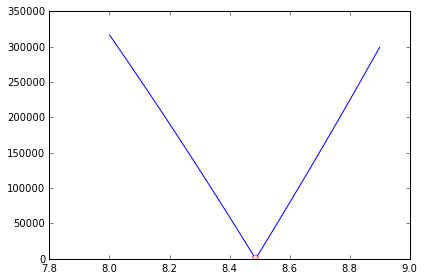

In [60]:
# Wind speed should be determined, assuming the the turbine is the observer of wind speed and work backward from power
# through generator efficiency and Cp to determine the speed for a case where the turbine operates non-yawed

## JARED CAN YOU PROPOSE SOMETHING NICER?

sowfaRefPower = avPowersYaw[3,0]
rotorArea = np.pi * (rotorDiameter/2.)**2
#rot
Cp_Interp = interp1d( NREL5MWCPCT['wind_speed'],  NREL5MWCPCT['CP'])
def powerError(ws): 
    Cp = Cp_Interp(ws)
    estPower =   generatorEfficiency*(0.5*air_density*rotorArea*Cp*np.power(ws, 3))
    return abs(sowfaRefPower - estPower)

# solve for the inflow velocity using a simple power model and the Cp/wind_speed curve
res = minimize(powerError,8.0,bounds=[(4,20)])#,method='SLSQP')

##### leaving this for comparison purposes. TODO: remove the hand tuning section
opt_wind_speed = res['x']
print opt_wind_speed

# Doing it by hand...
wind_speeds = np.linspace(8.0,8.9,100)
pow_ers =  [powerError(wind_speed) for wind_speed in wind_speeds]                        

#Set the wind speed
wind_speed = 8.485

fig, ax = plt.subplots(1,1)
ax.plot(wind_speeds,pow_ers)

ax.plot(wind_speed,powerError(wind_speed),'o', mfc='w', mec='r')
ax.plot(wind_speed,powerError(opt_wind_speed),'rx')
################

wind_speed = res['x']

### Build the FLORIS model

In [61]:
# In first scenarios, we will use a two turbine setup

In [62]:
nTurbines = 2

In [63]:
# Definte the original FLORIS model within openmdao

# global prob
prob = Problem(root=Group())
# Add a FLORIS model
prob.root.add('FLORIS', DirectionGroup(nTurbines, use_rotor_components=rotor,
                                           datasize=datasize, differentiable=differentiable), promotes=['*'])
# set up problem
prob.setup(check=False)

# Add Cp-Ct information
if rotor:
    prob['gen_params:windSpeedToCPCT_CP'] = NREL5MWCPCT['CP']
    prob['gen_params:windSpeedToCPCT_CT'] = NREL5MWCPCT['CT']
    prob['gen_params:windSpeedToCPCT_wind_speed'] = NREL5MWCPCT['wind_speed']
    prob['floris_params:useWakeAngle'] = True
    prob['floris_params:adjustInitialWakeDiamToYaw'] = False
    prob['floris_params:axialIndProvided'] = False
    prob['floris_params:useaUbU'] = True
    
# Assign all neccessary FLORIS parameters
prob['gen_params:pP'] = pP
prob['floris_params:kd'] = kd
prob['floris_params:initialWakeAngle'] = initialWakeAngle
prob['floris_params:initialWakeDisplacement'] = initialWakeDisplacement
prob['floris_params:bd'] = bd
prob['floris_params:ke'] = ke
prob['floris_params:me'] = me
prob['floris_params:MU'] = MU
prob['floris_params:aU'] = aU
prob['floris_params:bU'] = bU
prob['floris_params:cos_spread'] = cos_spread
prob['rotorDiameter'] =  np.array([rotorDiameter for i in range(nTurbines)])
prob['axialInduction'] = np.zeros(nTurbines) ## Not needed?
prob['generatorEfficiency'] = np.array([generatorEfficiency for i in range(nTurbines)])
prob['yaw0'] = np.zeros(nTurbines)
prob['wind_speed'] = wind_speed
prob['air_density'] = air_density
prob['wind_direction'] = wind_direction

NameError: name 'DirectionGroup' is not defined

In [64]:
# Definte the tuned FLORIS model within openmdao

# global prob
probTuned = Problem(root=Group())
# Add a FLORIS model
probTuned.root.add('FLORIS', DirectionGroup(nTurbines, use_rotor_components=rotor,
                                           datasize=datasize, differentiable=differentiable), promotes=['*'])
# set up problem
probTuned.setup(check=False)

# Add Cp-Ct information
if rotor:
    probTuned['gen_params:windSpeedToCPCT_CP'] = NREL5MWCPCT['CP']
    probTuned['gen_params:windSpeedToCPCT_CT'] = NREL5MWCPCT['CT']
    probTuned['gen_params:windSpeedToCPCT_wind_speed'] = NREL5MWCPCT['wind_speed']
    probTuned['floris_params:useWakeAngle'] = True
    probTuned['floris_params:adjustInitialWakeDiamToYaw'] = False
    probTuned['floris_params:axialIndProvided'] = False
    probTuned['floris_params:useaUbU'] = True
    
# Assign all neccessary FLORIS parameters
probTuned['gen_params:pP'] = pP
probTuned['floris_params:kd'] = kd
probTuned['floris_params:initialWakeAngle'] = initialWakeAngle
probTuned['floris_params:initialWakeDisplacement'] = initialWakeDisplacement
probTuned['floris_params:bd'] = bd
probTuned['floris_params:ke'] = ke
probTuned['floris_params:me'] = me
probTuned['floris_params:MU'] = MU
probTuned['floris_params:aU'] = aU
probTuned['floris_params:bU'] = bU
probTuned['floris_params:cos_spread'] = cos_spread
probTuned['rotorDiameter'] =  np.array([rotorDiameter for i in range(nTurbines)])
probTuned['axialInduction'] = np.zeros(nTurbines) ## Not needed?
probTuned['generatorEfficiency'] = np.array([generatorEfficiency for i in range(nTurbines)])
probTuned['yaw0'] = np.zeros(nTurbines)
probTuned['wind_speed'] = wind_speed
probTuned['air_density'] = air_density
probTuned['wind_direction'] = wind_direction

NameError: name 'DirectionGroup' is not defined

In [65]:
# Small tuning adjustment example
# In this toy example, remove initial wake angle

# probTuned['gen_params:pP'] = 1.88 # 1.88
# probTuned['floris_params:ke'] = 0.05 # 0.05
probTuned['floris_params:initialWakeAngle'] = 0.0 # 1.5
# probTuned['floris_params:kd'] = 0.17 # 0.17

AttributeError: 'unknowns' has not been initialized, setup() must be called before 'floris_params:initialWakeAngle' can be accessed

### Define a comparison plotting function

In [36]:
# Define a power comparison plotting function
def ComparePower(xPoints,sowfaPower,FLORISpower,FLORISpowerTuned,xlabel=''):

    fig, axarr = plt.subplots(3,2,figsize=(10,8),sharex=True)

    # Plot turbine 0
    ax = axarr[0,0]
    ax.plot(xPoints,sowfaPower[:,0]/1000.,'x--',label='SOWFA')
    ax.plot(xPoints,FLORISpower[:,0],'go-',label='FLORIS')
    ax.plot(xPoints,FLORISpowerTuned[:,0],'rs-',label='FLORIS-Tuned')
    ax.set_title('Turbine 0')
    ax.legend(loc="lower center")

    ax = axarr[0,1]
    ax.plot(xPoints,100 * np.abs(FLORISpower[:,0] - sowfaPower[:,0]/1000.)/(sowfaPower[:,0]/1000.),'go-',label='FLORIS')
    ax.plot(xPoints,100 * np.abs(FLORISpowerTuned[:,0] - sowfaPower[:,0]/1000.)/(sowfaPower[:,0]/1000.),'rs-',label='FLORIS-Tuned')
    ax.set_title('Turbine 0: % Error')

    # Plot turbine 1
    ax = axarr[1,0]
    ax.plot(xPoints,sowfaPower[:,1]/1000.,'x--',label='SOWFA')
    ax.plot(xPoints,FLORISpower[:,1],'go-',label='FLORIS')
    ax.plot(xPoints,FLORISpowerTuned[:,1],'rs-',label='FLORIS-Tuned')
    ax.set_title('Turbine 1')
    #ax.legend()

    ax = axarr[1,1]
    ax.plot(xPoints,100 * np.abs(FLORISpower[:,1] - sowfaPower[:,1]/1000.)/(sowfaPower[:,1]/1000.),'go-',label='FLORIS')
    ax.plot(xPoints,100 * np.abs(FLORISpowerTuned[:,1] - sowfaPower[:,1]/1000.)/(sowfaPower[:,1]/1000.),'rs-',label='FLORIS-Tuned')
    ax.set_title('Turbine 1: % Error')

    # Plot total power
    ax = axarr[2,0]
    totalSOWFA = np.sum(sowfaPower,axis=1)
    totalFLORIS = np.sum(FLORISpower,axis=1)
    totalFLORISTuned = np.sum(FLORISpowerTuned,axis=1)
    ax.plot(xPoints,totalSOWFA/1000.,'x--',label='SOWFA')
    ax.plot(xPoints,totalFLORIS,'go-',label='FLORIS')
    ax.plot(xPoints,totalFLORISTuned,'rs-',label='FLORIS-Tuned')
    ax.set_title('Total')
    ax.set_xlabel(xlabel)
    #ax.legend()

    ax = axarr[2,1]
    ax.plot(xPoints,100 * np.abs(totalFLORIS - totalSOWFA/1000.)/(totalSOWFA/1000.),'go-',label='FLORIS')
    ax.plot(xPoints,100 * np.abs(totalFLORISTuned - totalSOWFA/1000.)/(totalSOWFA/1000.),'rs-',label='FLORIS-Tuned')
    ax.set_title('Total: % Error')
    ax.set_xlabel(xlabel)

### Compare to 4D yaw powers

In [37]:
# Set the turbine positions
prob['turbineX'] = np.array([1118.1, 1556.0])
prob['turbineY'] = np.array([1279.5, 1532.3])
FLORISpower = list()

probTuned['turbineX'] = np.array([1118.1, 1556.0])
probTuned['turbineY'] = np.array([1279.5, 1532.3])
FLORISpowerTuned = list()

for yaw1 in yawPos:
    prob['yaw0'] = np.array([yaw1, 0.0])
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))

    probTuned['yaw0'] = np.array([yaw1, 0.0])
    probTuned.run()
    FLORISpowerTuned.append(list(probTuned['wtPower0']))
    
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)
FLORISpowerTuned = np.array(FLORISpowerTuned)

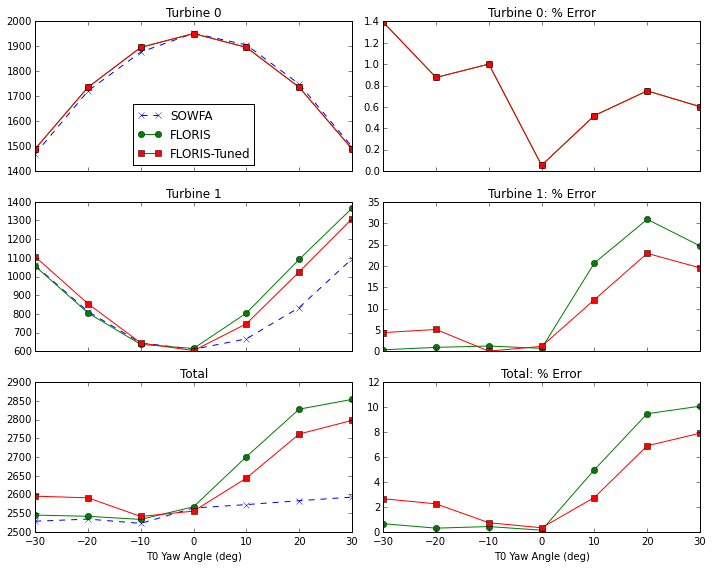

In [38]:
# Compare the power for this case
ComparePower(yawPos,avPowersYaw,FLORISpower,FLORISpowerTuned,'T0 Yaw Angle (deg)')

### Compare spacing power

In [39]:
# Compare the powers as the downstream turbine is located at various spacings

In [40]:
# Set up the domain for this case where turb0 is fixed, but turbine 2 is moved downstream
turb0_x = 1118.1
turb0_y = 1279.5

turb1_x = [1337.0,1556.0,1774.9,1993.8,2212.7]
turb1_y = [1405.9,1532.3,1658.7,1785.1,1911.5]

FLORISpower = list()
FLORISpowerTuned = list()

# Reset yaw
prob['yaw0'] = np.array([0.0, 0.0])
probTuned['yaw0'] = np.array([0.0, 0.0])

for sIDX in range(len(spacing)):   

    prob['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    prob['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    
    probTuned['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    probTuned['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    probTuned.run()
    FLORISpowerTuned.append(list(probTuned['wtPower0']))
    
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)
FLORISpowerTuned = np.array(FLORISpowerTuned)


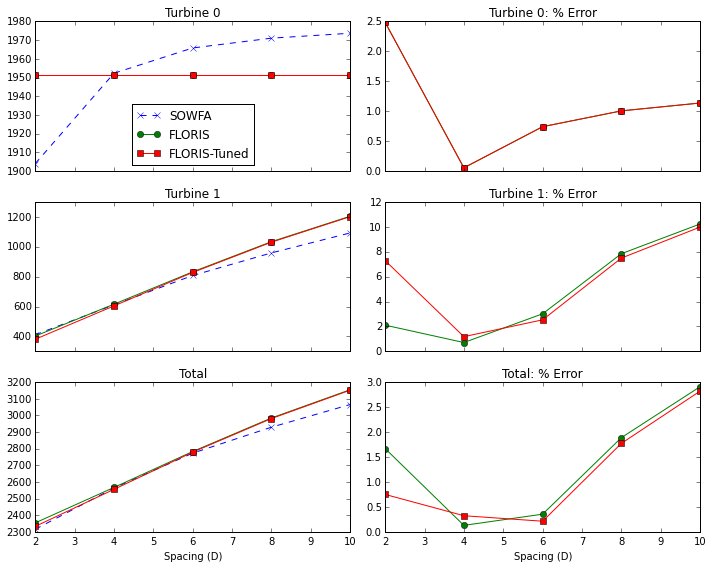

In [41]:
# Compare the power for this case
ComparePower(spacing,avPowersSpace,FLORISpower,FLORISpowerTuned,'Spacing (D)')

### Compare crosswind locations (4D)

In [42]:
# In this case, the downwind turbine is relocated cross-wind to investigate behavior of partial wake overlap conditions
# Set up the domain for this case where turb0 is fixed, but turbine 2 is moved downstream
turb0_x = 1118.1
turb0_y = 1279.5

turb1_x = [1526.0,1541.0,1556.0,1571.0,1586.0]
turb1_y = [1584.3,1558.3,1532.3,1506.3,1480.3]

FLORISpower = list()
FLORISpowerTuned = list()

# Reset yaw
prob['yaw0'] = np.array([0.0, 0.0])
probTuned['yaw0'] = np.array([0.0, 0.0])

for sIDX in range(len(offset4D)):   

    prob['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    prob['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    
    probTuned['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    probTuned['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    probTuned.run()
    FLORISpowerTuned.append(list(probTuned['wtPower0']))
    
    time.sleep(0.001)
    
FLORISpower = np.array(FLORISpower)
FLORISpowerTuned = np.array(FLORISpowerTuned)

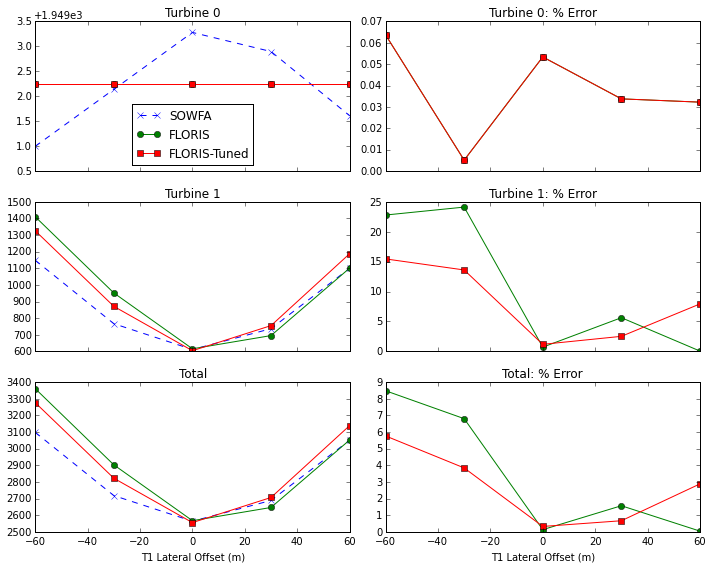

In [43]:
# Compare the power for this case
ComparePower(offset4D,avPowersOffset4D,FLORISpower,FLORISpowerTuned,'T1 Lateral Offset (m)')

### Compare crosswind locations (6D)

In [44]:
# In this case, the downwind turbine is relocated cross-wind to investigate behavior of partial wake overlap conditions
# Set up the domain for this case where turb0 is fixed, but turbine 2 is moved downstream
turb0_x = 1118.1
turb0_y = 1279.5

turb1_x = [1744.9,1759.9,1774.9,1789.9,1804.9]
turb1_y = [1710.7,1684.7,1658.7,1632.7,1606.7]

FLORISpower = list()
FLORISpowerTuned = list()

# Reset yaw
prob['yaw0'] = np.array([0.0, 0.0])
for sIDX in range(len(offset6D)):   

    prob['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    prob['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))

    probTuned['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    probTuned['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    probTuned.run()
    FLORISpowerTuned.append(list(probTuned['wtPower0']))
    
    time.sleep(0.001)
    
FLORISpower = np.array(FLORISpower)
FLORISpowerTuned = np.array(FLORISpowerTuned)

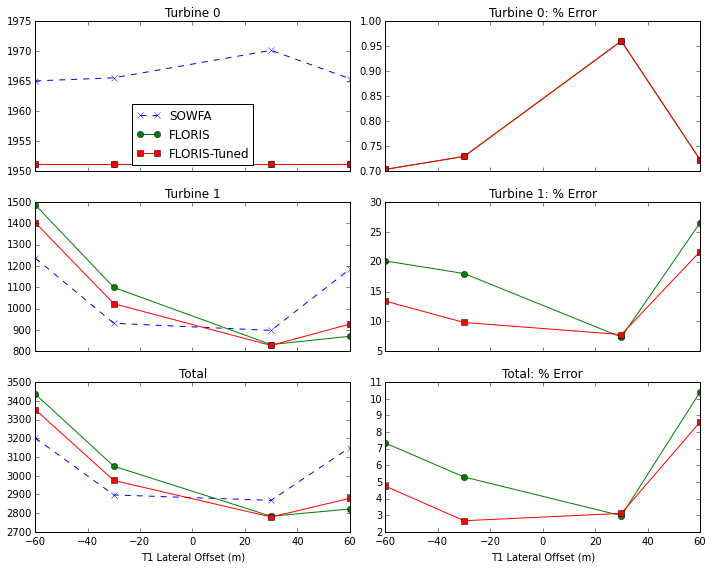

In [45]:
# Compare the power for this case
ComparePower(offset6D,avPowersOffset6D,FLORISpower,FLORISpowerTuned,'T1 Lateral Offset (m)')

## Compare 1 Turbine wake profiles (turbine sampling method)

In [48]:
# Also available are downwind profiles from a single turbine simulation in SOWFA

In [49]:
# NOTE SAMPLING IS DONE HERE USING A SECOND TURBINE SWEPT ACROSS LOCATIONS
# THE ADVANTAGE IS THAT THE TURBINE SAMPLES A SPACE LARGER THAN A SINGLE POTNI AND PRODUCES AN EFFECTIVE
# WIND SPEED AT EACH POINT INCLUDING WAKE OVERLAPS

In [50]:
# Load the downwind profiles
downStreamLocs,ySampling,caseNames,wakeProfiles = pickle.load( open( os.path.join('data','wakeProfiles.p'), "rb" ) )

In [51]:
# Identify local variables
yawAngles = caseNames #angle of turbine in deg
numYaw = len(yawAngles)
numDownStreamLocs = len(downStreamLocs)
numSamples = len(ySampling)


# ySampling gives (in D) a lateral offset from a given downstream location, need to convert this actual FLORIS positons
# assume for now initial turbine at 0, and downwind along x axis


In [52]:
# Convert yaw angles
yawAngles = np.array([float(y) for y in yawAngles])
print caseNames
print yawAngles

['-30', '-20', '-10', '0', '10', '20', '30']
[-30. -20. -10.   0.  10.  20.  30.]


In [53]:
## TODO MAYBE ITS NEATER TO COPY PROB TO A NEW PROBLEM TO AVOID BACK AND FORTH ERRORS

In [54]:
# Let's redo prob for 1-turbine case
# Inflow conditions
wind_direction = 270 # Lets go right down x for this case
prob['wind_direction'] = wind_direction
probTuned['wind_direction'] = wind_direction

In [55]:
# Put a signle turbine at 0
turb0_x = 0.0
turb0_y = 0.0

In [56]:
wakeProfiles;

In [57]:
# Now run a loop to probe
florisSample = list()
for yIdx, yaw in enumerate(yawAngles):
    florisSample.append(np.zeros((numSamples,numDownStreamLocs)))
    prob['yaw0'] = np.array([yaw, 0.0])
    for s in range(numSamples):
        for d in range(numDownStreamLocs):
            prob['turbineX'] = np.array([turb0_x, downStreamLocs[d] * rotorDiameter])
            prob['turbineY'] = np.array([turb0_y, ySampling[s] * rotorDiameter])
            prob.run()
            florisSample[yIdx][s,d] = prob['wtVelocity0'][1]

In [58]:
# Rerun for prob tunes
florisSampleTuned = list()
for yIdx, yaw in enumerate(yawAngles):
    florisSampleTuned.append(np.zeros((numSamples,numDownStreamLocs)))
    probTuned['yaw0'] = np.array([yaw, 0.0])
    for s in range(numSamples):
        for d in range(numDownStreamLocs):
            probTuned['turbineX'] = np.array([turb0_x, downStreamLocs[d] * rotorDiameter])
            probTuned['turbineY'] = np.array([turb0_y, ySampling[s] * rotorDiameter])
            probTuned.run()
            florisSampleTuned[yIdx][s,d] = probTuned['wtVelocity0'][1]

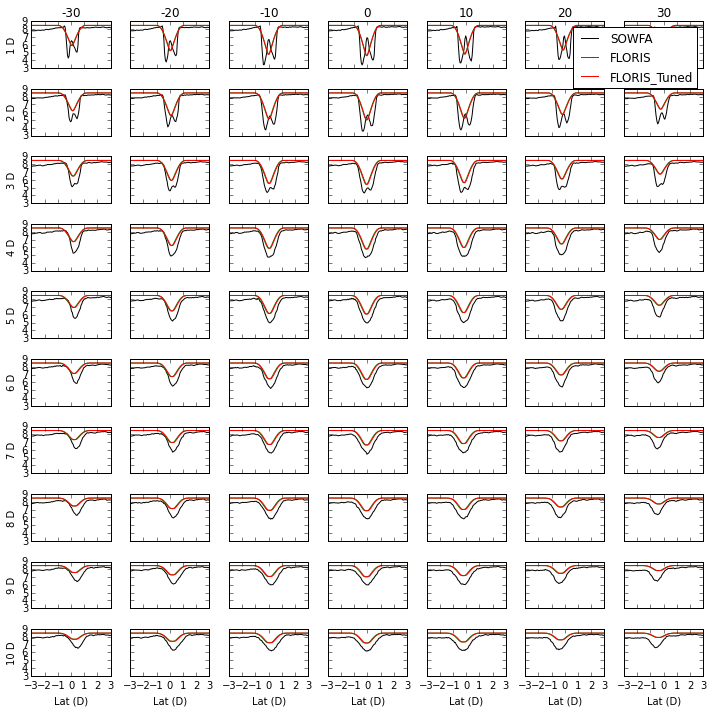

In [59]:
# Compare the profiles

fig, axarr = plt.subplots(numDownStreamLocs,numYaw,figsize=(10,10),sharex=True,sharey=True)
for yIdx in range(numYaw):
    for dIdx in range(numDownStreamLocs):
        ax = axarr[dIdx,yIdx]
        ax.plot(ySampling,wakeProfiles[dIdx][yIdx],'k',label='SOWFA')
        ax.plot(ySampling,florisSample[yIdx][:,dIdx],'g',label='FLORIS')
        ax.plot(ySampling,florisSampleTuned[yIdx][:,dIdx],'r',label='FLORIS_Tuned')
        axarr[dIdx,0].set_ylabel('%d D' % downStreamLocs[dIdx])
    axarr[0,yIdx].set_title(caseNames[yIdx])
    axarr[-1,yIdx].set_xlabel('Lat (D)')
    
axarr[0,-1].legend()

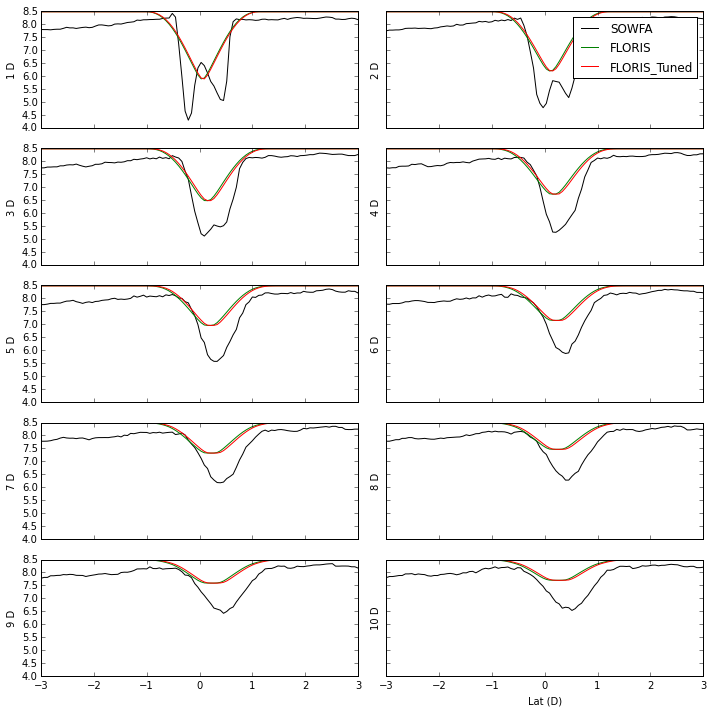

In [60]:
# Zoom in on just the 0 yaw case
# Compare the profiles

yIdx = 0
fig, axarr = plt.subplots(numDownStreamLocs/2,2,figsize=(10,10),sharex=True,sharey=True)
axarr =  axarr.flatten()
for dIdx in range(numDownStreamLocs):
    ax = axarr[dIdx]
    ax.plot(ySampling,wakeProfiles[dIdx][yIdx],'k',label='SOWFA')    
    ax.plot(ySampling,florisSample[yIdx][:,dIdx],'g',label='FLORIS')
    ax.plot(ySampling,florisSampleTuned[yIdx][:,dIdx],'r',label='FLORIS_Tuned')
    axarr[dIdx].set_ylabel('%d D' % downStreamLocs[dIdx])
axarr[-1].set_xlabel('Lat (D)')
    
axarr[1].legend()

# TO DELETE

In [284]:
# ICOWES 2 STUFF

In [285]:
prob['turbineX'] = np.array([1118.1, 1881.9])
prob['turbineY'] = np.array([1279.5, 1720.5])
FLORISpower = list()
for yaw1 in yawPosI2:
    prob['yaw0'] = np.array([yaw1, 0.0])
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

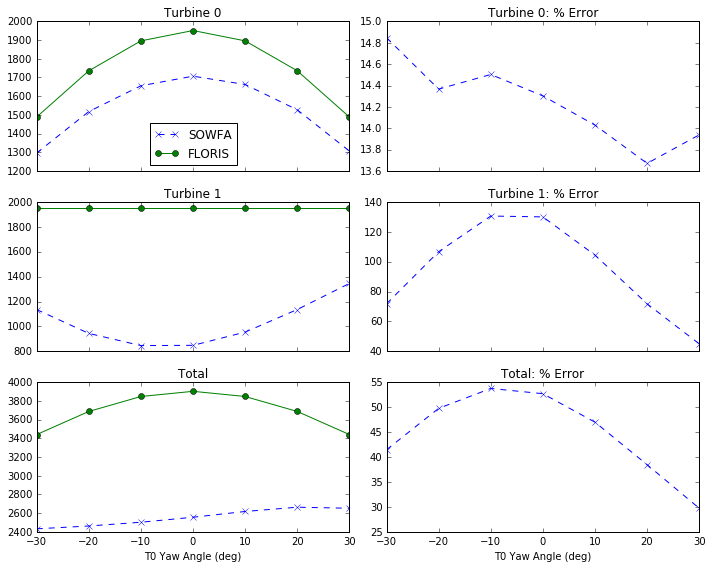

In [286]:
# Compare the power for this case
ComparePower(yawPosI2,avPowersYawI2,FLORISpower,'T0 Yaw Angle (deg)')